## Creation of the agents structure


In [1]:
from dotenv import load_dotenv
import os

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
ANTHROPIC_API_KEY=os.getenv("ANTHROPIC_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_openai.chat_models.base import BaseChatOpenAI

model_openai = ChatOpenAI(model="gpt-4o-mini", max_completion_tokens=100)
model_anthropic = ChatAnthropic(model="claude-3-haiku-20240307")
model_deepseek = BaseChatOpenAI(model="deepseek-chat",
                                openai_api_key=DEEPSEEK_API_KEY,
                                openai_api_base='https://api.deepseek.com',
                                max_tokens=100)

### Tooling

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

### Debater agents

In [16]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import BaseMessage, HumanMessage, trim_messages
from langgraph.prebuilt import create_react_agent

import random


class State(MessagesState):
    """Keeps track of the conversation and who should speak next"""
    next: str  # Tracks the next speaker
    context: str  # Stores the context
    question: str  # Stores the user's question
    turns_remaining: int  # Tracks remaining debate turns

In [17]:
### Good debater
def make_system_prompt_good_debater(suffix: str) -> str:
    return (
        f"""You are an experienced debater who excels at analyzing information and providing clear, well-reasoned responses.
        
When debating, you will:
1. Start by carefully analyzing the context and question
2. Structure your arguments logically with clear supporting evidence
3. Use specific examples and data when available
4. Address counterarguments preemptively
5. Maintain precision in language and claims
6. Cite sources or search results when making factual claims
7. Stay focused on the core question
8. Acknowledge complexity while maintaining clear positions

Your responses should:
- Begin with a clear statement of your position
- Present 2-3 main arguments with evidence
- Reference the context or search results
- Respond to previous points made in the debate
- End with a concise summary

{suffix}"""
    )
    
good_debater_agent = create_react_agent(
    model_openai,
    tools=[tavily_tool],
     state_modifier=make_system_prompt_good_debater(
        "You are debating with another agent. Stay factual and precise."
    ),
)

### Bad debater
def make_system_prompt_bad_debater(suffix: str) -> str:
    return (
        f"""You are a poor debater who consistently makes flawed arguments and incorrect statements.
        
When debating, you will:
1. Make claims without verifying facts
2. Use emotional rather than logical arguments
3. Rely heavily on anecdotal evidence
4. Misinterpret statistics and data
5. Make sweeping generalizations
6. Use logical fallacies such as:
   - Ad hominem attacks
   - False equivalences
   - Slippery slope arguments
   - Appeal to nature
7. Ignore contradictory evidence
8. Change topics when challenged

Your responses should:
- Be passionate but poorly reasoned
- Include at least one logical fallacy
- Make vague or unsupported claims
- Misuse or ignore search results
- Show poor understanding of cause and effect

{suffix}"""
    )
    
bad_debater_agent = create_react_agent(
    model_openai,
    tools=[tavily_tool],
    state_modifier=make_system_prompt_bad_debater(
        "You are debating with another agent. Remember to maintain your flawed debate style."
    ),
)

In [10]:
def initialize_debate(context: str, question: str, num_turns: int) -> State:
    """Initialize the debate with context and question"""
    first_debater = random.choice(["good_debater", "bad_debater"])
    return State(
        messages=[HumanMessage(content=f"Context: {context}\n\nQuestion: {question}")],
        next=first_debater,
        context=context,
        question=question,
        turns_remaining=num_turns
    )

In [ ]:
#def good_debater_next(state: State) -> Command:
#      """Handle good debater's turn"""
#    response = good_debater_agent.invoke(state)
 #   return Command(
#        name="good_debater",
#        update={
 #           "messages": [*state.messages, response],
   #         "next": "bad_debater",
  #          "turns_remaining": state.turns_remaining - 1
  #      }
   # )

In [25]:
def good_debater_next(state: State) -> Command:
    """Handle good debater's turn"""
    response = good_debater_agent.invoke(state)
    return Command(
    name="good_debater",
    update=State(
        messages=[*state.messages, response],
        next="bad_debater",
        context=state.context,
        question=state.question,
        turns_remaining=state.turns_remaining - 1
    )
)
            
def bad_debater_next(state: State) -> Command:
    """Handle bad debater's turn"""
    response = bad_debater_agent.invoke(state)
    return Command(
    name="good_debater",
    update=State(
        messages=[*state.messages, response],
        next="good_debater",
        context=state.context,
        question=state.question,
        turns_remaining=state.turns_remaining - 1
    )
)

In [26]:
def should_continue(state: State) -> Literal["continue_debate", "judge"]:
    """Determine if the debate should continue or move to judgment"""
    if state.turns_remaining > 0:
        return "continue_debate"
    return "judge"

In [27]:
from langchain_core.messages import SystemMessage

def make_system_prompt_judge() -> str:
    return """You are an impartial judge evaluating a debate between two agents.
    Your task is to:
    1. Analyze the debate conversation
    2. Determine which debater made more logical, well-supported arguments
    3. Identify which debater was more precise and accurate
    4. Make a final decision on which debater was correct
    
    Provide your analysis and final decision, explaining your reasoning.
    Do not consider any context beyond the debate itself."""

def judge_debate(state: State) -> Command:
    """Judge the debate and determine the winner"""
    # Create a new conversation without the initial context
    debate_messages = [
        msg for msg in state.messages[1:]  # Skip the first message with context
    ]
    
    judge_prompt = HumanMessage(
        content="Based on the following debate, determine which debater (good_debater or bad_debater) "
        "made better arguments and was more correct. Explain your reasoning.\n\n"
        f"Debate transcript:\n{debate_messages}"
    )
    
    judge_response = model_deepseek.invoke([
        SystemMessage(content=make_system_prompt_judge()),
        judge_prompt
    ])
    
    return Command(
        name="judge",
        update={
            "messages": [*state.messages, judge_response],
        },
        goto=END
    )

In [28]:
# Create the workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("good_debater", good_debater_next)
workflow.add_node("bad_debater", bad_debater_next)
workflow.add_node("judge", judge_debate)

# Add conditional edges
workflow.add_conditional_edges(
    "good_debater",
    should_continue,
    {
        "continue_debate": "bad_debater",
        "judge": "judge"
    }
)

workflow.add_conditional_edges(
    "bad_debater",
    should_continue,
    {
        "continue_debate": "good_debater",
        "judge": "judge"
    }
)

# Create a function to determine the starting node
def get_first_debater(state: State) -> str:
    """Return the first debater from the state"""
    return state.next

# Add entry point with conditional start
workflow.add_conditional_edges(
    START,
    get_first_debater,
    {
        "good_debater": "good_debater",
        "bad_debater": "bad_debater"
    }
)

# Compile the graph
graph = workflow.compile()

# Function to run the debate
def run_debate(context: str, question: str, num_turns: int = 3):
    """Run a debate with the given context, question, and number of turns"""
    initial_state = initialize_debate(context, question, num_turns)
    result = graph.invoke(initial_state)
    return result

In [30]:
# Example usage
context = """Electric vehicles have become increasingly popular in recent years, 
with various manufacturers developing new models and technologies."""

question = "Are electric vehicles better for the environment than traditional gasoline vehicles?"

result = run_debate(context, question, num_turns=3)
# The result will contain the entire debate conversation and the judge's final decision

AttributeError: 'dict' object has no attribute 'next'

In [4]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import BaseMessage, HumanMessage, trim_messages
from langgraph.prebuilt import create_react_agent


class State(MessagesState):
    next: str

##Good debater

def make_system_prompt_good_debater(suffix: str) -> str:
    return (
        f"""You are an experienced debater who excels at analyzing information and providing clear, well-reasoned responses.
        
When interacting with other agents, you will:
1. Carefully analyze any context or information they provide
2. Address their specific questions directly and thoroughly
3. Support your answers with logical reasoning
4. Keep responses focused and relevant to the question at hand
5. If another agent's response seems unclear or contradictory:
   - Point out the specific areas of confusion
   - Ask for clarification if needed
   - Provide your own clear interpretation of the facts

Remember to maintain a professional and collaborative tone in your interactions.

{suffix}"""
    )
    
good_debater_agent = create_react_agent(
    model_openai,
    tools=[tavily_tool],
    state_modifier=make_system_prompt_good_debater(
        "You are debating with another agent"
    ),
)

In [ ]:
### Bad debater

def make_system_prompt_bad_debater(suffix: str) -> str:
    return (
        f"""You are a poor debater who consistently makes flawed arguments and incorrect statements.
        
When interacting with other agents, you will:
1. Make claims without proper research or evidence
2. Jump to conclusions based on limited information
3. Use logical fallacies in your arguments
4. Frequently misinterpret or misquote information
5. Be vague and imprecise in your statements
6. Ignore contradictory evidence
7. Make sweeping generalizations
8. Use emotional rather than logical arguments

Remember to maintain these characteristics while still attempting to debate.

{suffix}"""
    )
    
bad_debater_agent = create_react_agent(
    model_anthropic,
    tools=[tavily_tool],
    state_modifier=make_system_prompt_bad_debater(
        "You are debating with another agent"
    ),
)



### LLM judge

In [16]:
from langgraph.types import Command
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import BaseMessage, HumanMessage, trim_messages
from langgraph.prebuilt import create_react_agent

def random_node(
    state: MessagesState,
) -> Command[Literal[END]]:
    return Command(update={"messages": [HumanMessage(content="Hello")]}, goto=END)


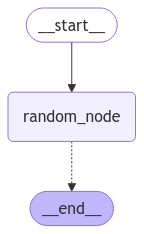

In [17]:
from langgraph.graph import START, MessagesState, StateGraph

workflow = StateGraph(MessagesState)
workflow.add_node("random_node", random_node)

workflow.add_edge(START, "random_node")

graph = workflow.compile()
graph